# Complexity and similarity

## Required Packages

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import seaborn as sns

from tqdm import tqdm

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity

C:\Users\rzp98\AppData\Local\Temp\ipykernel_16432\2587638764.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [12]:
# load preprocessed and normalised data 
df_review_norm = pd.read_csv("df_camera_normalised.csv")
df_product_norm = pd.read_csv('product_cleaned.csv')

df_review_norm.dropna(subset=['reviewText'], inplace=True)

C:\Users\rzp98\AppData\Local\Temp\ipykernel_16432\3223943309.py:2: DtypeWarning: Columns (5) have mixed types. Specify dtype option on import or set low_memory=False.
  df_review_norm = pd.read_csv("df_camera_normalised.csv")


In [3]:
df_review_norm = df_review_norm[['overall', 'reviewText', 'Year']]
df_review_norm.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2495753 entries, 0 to 2502222
Data columns (total 3 columns):
 #   Column      Dtype  
---  ------      -----  
 0   overall     float64
 1   reviewText  object 
 2   Year        int64  
dtypes: float64(1), int64(1), object(1)
memory usage: 76.2+ MB


<Axes: xlabel='Year'>

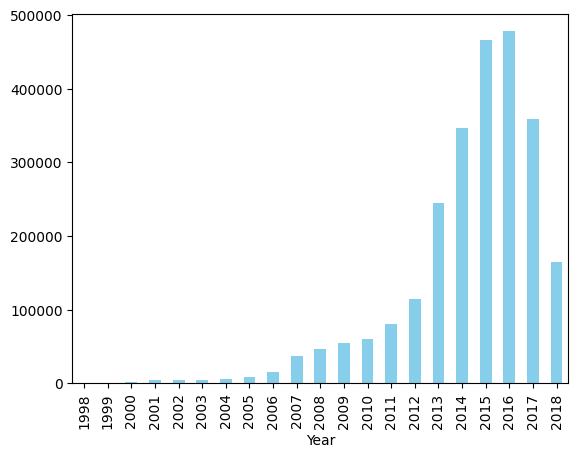

In [4]:
df_review_norm["Year"].value_counts().sort_index().plot(kind='bar', color='skyblue')

## Similarity analysis

In [5]:
# define some useful functions
def create_feature_matrices_by_year(df, start_year, end_year, vectorizer_type):
    vectorizer = vectorizer_type(ngram_range=(1, 1))
    years = range(start_year, end_year + 1)
    
    dfm_by_year = {}
    
    for year in years:
        yearly_reviews = df[df['Year'] == year]['reviewText']
        dfm = vectorizer.fit_transform(yearly_reviews)
        dfm = dfm.astype(np.int16) # drop precision to save memory, max range: [-32768, 32767]
        dfm_dense = dfm.todense()
        feature_names = vectorizer.get_feature_names_out()
        dfm_df = pd.DataFrame(dfm_dense, columns=feature_names)
        dfm_by_year[year] = dfm_df
        del dfm_df
    
    return dfm_by_year

def average_and_transpose(dfm_by_year):
    avg_by_year = {}
    
    for year, dfm in dfm_by_year.items():
        avg_by_year[year] = dfm.mean(axis=0)
    
    avg_df = pd.DataFrame(avg_by_year)
    avg_df.fillna(0, inplace=True)
    avg_df = avg_df.T
    
    return avg_df

In [6]:
# unified create_feature_matrices_by_year and average_and_transpose to save memory
def dfm_yearly_avg_t (df, start_year, end_year, vectorizer_type):
    vectorizer = vectorizer_type(ngram_range=(1, 1))
    years = range(start_year, end_year + 1)
    
    dfm_by_year_avg_t = {}
    
    for year in tqdm(years):
        yearly_reviews = df[df['Year'] == year]['reviewText']
        dfm = vectorizer.fit_transform(yearly_reviews)
        dfm = dfm.astype(np.int16) # drop precision to save memory, max range: [-32768, 32767]
        dfm_dense = dfm.todense()
        feature_names = vectorizer.get_feature_names_out()
        dfm_df = pd.DataFrame(dfm_dense, columns=feature_names)
        dfm_by_year_avg_t[year] = dfm_df.mean(axis=0)

    avg_df = pd.DataFrame(dfm_by_year_avg_t)
    avg_df.fillna(0, inplace=True)
    avg_df = avg_df.T
    
    return avg_df


### Review similarity by year

#### Bag of words similarity approach

In [7]:
df_yearly_avg = dfm_yearly_avg_t(df=df_review_norm, start_year=2008, end_year=2018, vectorizer_type=TfidfVectorizer)
df_yearly_avg

100%|██████████| 11/11 [03:25<00:00, 18.64s/it]


,aa,aaa,aaaa,aaaaa,aaaaaa,aaaaaaa,aaaaaaaa,aaaaaaaaaa,aaaaaaaaaaa,aaaaaaaaaaaa,...,zzzzz,zzzzzz,zzzzzziggy,zzzzzzz,zzzzzzzzip,zzzzzzzzz,zzzzzzzzzz,zzzzzzzzzzip,zzzzzzzzzzzzzz,zzzzzzzzzzzzzzzzzzzzzzz
2008,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2009,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2010,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2011,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2012,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2013,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2014,0.000003,0.000061,0.000012,0.000020,0.000000,0.000003,0.000000,0.0,0.000003,0.000003,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2015,0.000006,0.000090,0.000009,0.000006,0.000006,0.000002,0.000000,0.0,0.000002,0.000000,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2016,0.000004,0.000063,0.000013,0.000002,0.000002,0.000000,0.000000,0.0,0.000004,0.000000,...,0.000002,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2017,0.000003,0.000042,0.000006,0.000008,0.000003,0.000003,0.000003,0.0,0.000000,0.000000,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


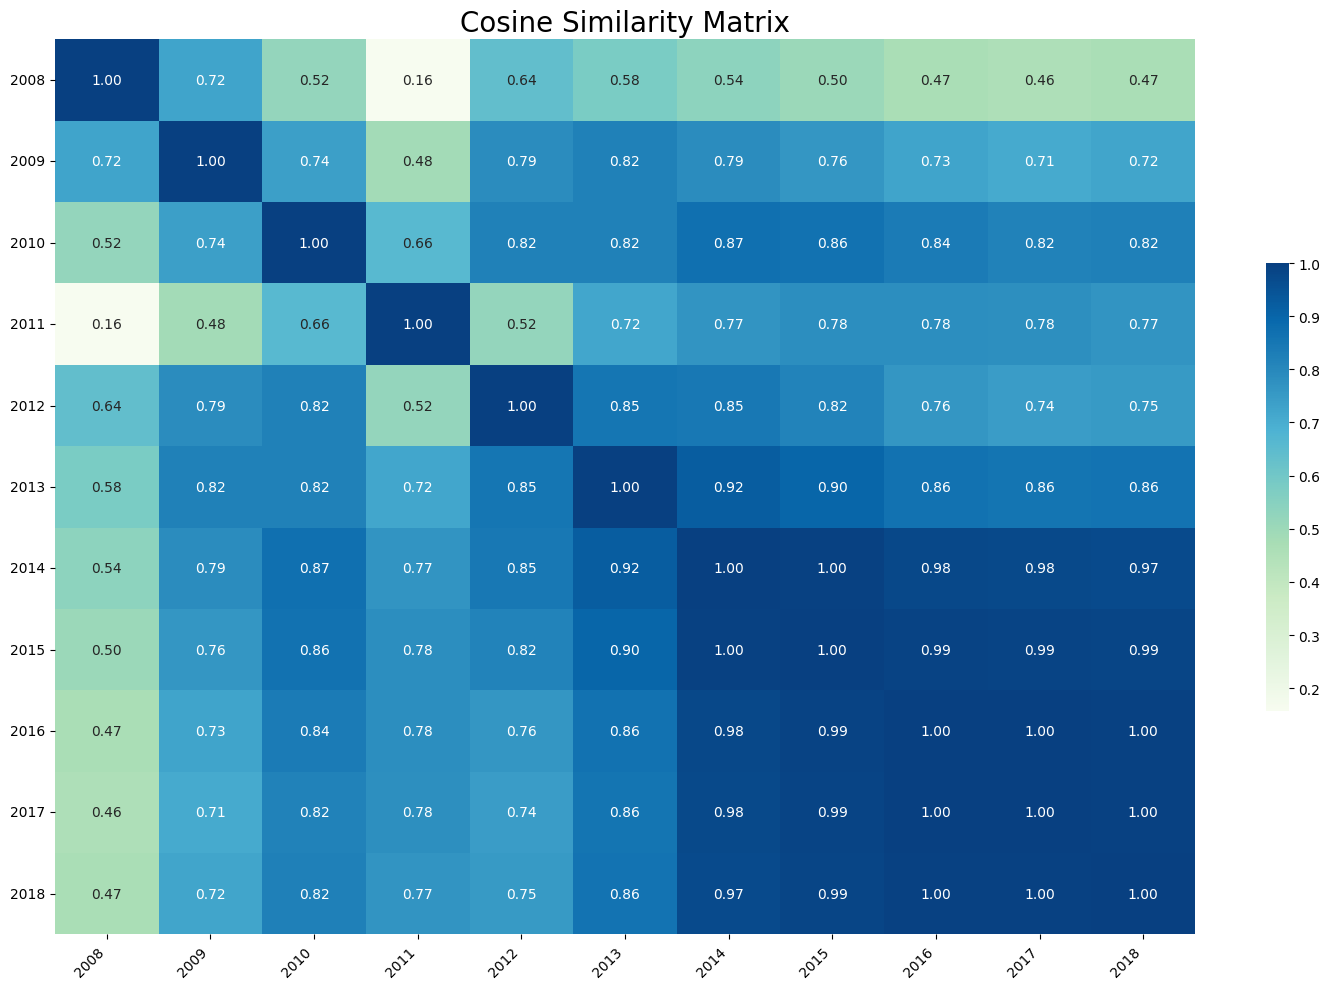

In [11]:
cosine_sim_matrix = cosine_similarity(df_yearly_avg)

plt.figure(figsize=(15, 10))
heatmap = sns.heatmap(cosine_sim_matrix, annot=True, cmap= "GnBu" , fmt=".2f",
                      xticklabels=df_yearly_avg.index, yticklabels=df_yearly_avg.index, cbar_kws={'shrink': .5})

# Improving aesthetics
heatmap.set_xticklabels(heatmap.get_xticklabels(), rotation=45, horizontalalignment='right')
heatmap.set_yticklabels(heatmap.get_yticklabels(), rotation=0)
plt.title('Cosine Similarity Matrix', fontsize=20)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.tight_layout()

#### Vec Embedding similarity approach

### Product description similarity by year

In [14]:
df_product_norm['date'].value_counts()

date
October 2, 2001                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                    